# 1. Kết nối tới drive , import một số thư viện cần thiết

In [202]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [203]:
import numpy.polynomial.polynomial as poly
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns


from datetime import datetime
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import Lasso
from sklearn.utils import column_or_1d

from keras.models import Sequential
from keras.layers import Dense, GRU
from keras.regularizers import L1L2

In [204]:
FPT = pd.read_csv("/content/drive/MyDrive/FPT/FPT-PTTK-doan.csv")

In [205]:
FPT

,Date,Close,Open,High,Low,Vol,Change
0,30/12/2016,15852.0,15707.9,15942.1,15617.8,3.79M,1.27%
1,03/01/2017,16158.2,15960.1,16194.3,15960.1,2.34M,1.93%
2,04/01/2017,16302.3,16140.2,16464.5,16104.2,2.36M,0.89%
3,05/01/2017,16248.3,16284.3,16356.4,16248.3,1.42M,-0.33%
4,06/01/2017,16194.3,16284.3,16392.4,16194.3,1.85M,-0.33%
...,...,...,...,...,...,...,...
1736,13/12/2023,95200.0,97400.0,97400.0,95200.0,2.15M,-1.65%
1737,14/12/2023,96200.0,95800.0,96400.0,95200.0,1.71M,1.05%
1738,15/12/2023,96200.0,96200.0,96300.0,95000.0,1.47M,0.00%
1739,18/12/2023,94000.0,95900.0,96200.0,93700.0,2.27M,-2.29%


In [206]:
FPT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1741 entries, 0 to 1740
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1741 non-null   object 
 1   Close   1741 non-null   float64
 2   Open    1741 non-null   float64
 3   High    1741 non-null   float64
 4   Low     1741 non-null   float64
 5   Vol     1741 non-null   object 
 6   Change  1741 non-null   object 
dtypes: float64(4), object(3)
memory usage: 95.3+ KB


In [228]:
# Convert "Date" column to datetime type
FPT['Date'] = pd.to_datetime(FPT['Date'])

# Convert "Vol" and "Change" columns to numeric types
FPT['Vol'] = pd.to_numeric(FPT['Vol'], errors='coerce')
FPT['Change'] = pd.to_numeric(FPT['Change'], errors='coerce')

# Sort the DataFrame by the "Date" column
FPT = FPT.sort_values('Date')


<ipython-input-228-4e52ebc033c0>:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  FPT['Date'] = pd.to_datetime(FPT['Date'])


# 2. Tiền xử lý dữ liệu

### Loại bỏ một số dữ liệu trống trong dataset

In [207]:
# Drop missing values
FPT = FPT.dropna()

In [208]:
FPT1 = FPT.reset_index()['Close']

In [209]:
FPT['Index'] = np.arange(len(FPT.index))

<h1> 3.Scale dữ liệu

In [210]:
scaler=MinMaxScaler(feature_range=(0,1))
FPT1=scaler.fit_transform(np.array(FPT1).reshape(-1,1))

# 4. Chia tập dữ liệu để train-test-validate theo tỉ lệ 7:2:1

In [211]:
# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(FPT1))
test_size = int(0.2 * len(FPT1))
val_size = len(FPT1) - train_size - test_size

In [212]:
train_data = FPT1[:train_size]
test_data = FPT1[train_size:train_size+test_size]
val_data = FPT1[train_size+test_size:]

<h1>Hàm Create Dataset

In [213]:
#Chuyển mảng giá trị của dataset thành ma trận
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [214]:
import numpy
#Reshape into X=t,t+1, t+2... t+99 and Y= t+100
time_step =100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [215]:
#Reshape input to be [samples, time steps, features] which is required for GRU
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [216]:
# Train a Lasso model
lasso = Lasso(alpha=0.01)
lasso.fit(X_train.reshape(X_train.shape[0], -1), y_train)

# Get Lasso coefficients as additional features
lasso_features_train = lasso.predict(X_train.reshape(X_train.shape[0], -1))
lasso_features_test = lasso.predict(X_test.reshape(X_test.shape[0], -1))
lasso_features_val = lasso.predict(X_val.reshape(X_val.shape[0], -1))

# Reshape Lasso features to be compatible for concatenation
lasso_features_train = lasso_features_train.reshape(-1, 1, 1)
lasso_features_test = lasso_features_test.reshape(-1, 1, 1)
lasso_features_val = lasso_features_val.reshape(-1, 1, 1)

# Concatenate Lasso features with original features
X_train_combined = np.concatenate([X_train, lasso_features_train.repeat(time_step, axis=1)], axis=2)
X_test_combined = np.concatenate([X_test, lasso_features_test.repeat(time_step, axis=1)], axis=2)
X_val_combined = np.concatenate([X_val, lasso_features_val.repeat(time_step, axis=1)], axis=2)


In [217]:
# Define GRU model with L1L2 regularization (mimicking Lasso)
model = Sequential()
model.add(GRU(64, input_shape=(time_step, 2)))  # 2 features: original + Lasso
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [279]:
y_test


array([0.94871431, 0.95366504, 0.91902197, 0.91902197, 0.91902197,
       0.91010585, 0.83388628, 0.8428024 , 0.82993291, 0.85467453,
       0.8497238 , 0.84477308, 0.84675577, 0.80221124, 0.74084386,
       0.78439103, 0.81904612, 0.75668138, 0.73687847, 0.7329251 ,
       0.79726052, 0.77746963, 0.7705362 , 0.77548693, 0.76558548,
       0.78242035, 0.8497238 , 0.85565987, 0.91703927, 0.91208855,
       0.89823372, 0.91703927, 0.91407124, 0.93881286, 0.9289114 ,
       0.95465038, 0.94871431, 0.95168235, 0.89921906, 0.83428282,
       0.86873364, 0.88536423, 0.90318445, 0.90318445, 0.90318445,
       0.86873364, 0.81409539, 0.82596752, 0.82596752, 0.83785167,
       0.87585932, 0.87942817, 0.83428282, 0.85567189, 0.84021889,
       0.82477791, 0.80221124, 0.7974648 , 0.80340086, 0.79389595,
       0.80221124, 0.79033911, 0.79389595, 0.78677026, 0.79627518,
       0.79627518, 0.81884184, 0.82003146, 0.82122108, 0.82477791,
       0.81765223, 0.82241069, 0.81884184, 0.80221124, 0.80815

In [218]:
#Model fitting
model.fit(X_train_combined, y_train, validation_data=(X_test_combined, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
18/18 [==============================] - 3s 65ms/step - loss: 0.0147 - val_loss: 0.0070
Epoch 2/100
18/18 [==============================] - 1s 31ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 3/100
18/18 [==============================] - 1s 30ms/step - loss: 2.4533e-04 - val_loss: 9.4885e-04
Epoch 4/100
18/18 [==============================] - 1s 32ms/step - loss: 1.1365e-04 - val_loss: 4.8468e-04
Epoch 5/100
18/18 [==============================] - 1s 32ms/step - loss: 9.2533e-05 - val_loss: 5.2326e-04
Epoch 6/100
18/18 [==============================] - 1s 31ms/step - loss: 9.1017e-05 - val_loss: 5.1211e-04
Epoch 7/100
18/18 [==============================] - 1s 32ms/step - loss: 8.8431e-05 - val_loss: 5.2775e-04
Epoch 8/100
18/18 [==============================] - 1s 30ms/step - loss: 8.6404e-05 - val_loss: 4.9900e-04
Epoch 9/100
18/18 [==============================] - 1s 32ms/step - loss: 8.5644e-05 - val_loss: 4.9751e-04
Epoch 10/100
18/18 [========================

<h1>Dự báo dữ liệu test, val

In [219]:
train_predict = model.predict(X_train_combined)
y_pred = model.predict(X_test_combined)
y_pred_val = model.predict(X_val_combined)


3/3 [==============================] - 0s 8ms/step


<h1>Chuẩn hóa dữ liệu

In [220]:
#Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [221]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
ytest

array([[94732.],
       [95144.],
       [92261.],
       [92261.],
       [92261.],
       [91519.],
       [85176.],
       [85918.],
       [84847.],
       [86906.],
       [86494.],
       [86082.],
       [86247.],
       [82540.],
       [77433.],
       [81057.],
       [83941.],
       [78751.],
       [77103.],
       [76774.],
       [82128.],
       [80481.],
       [79904.],
       [80316.],
       [79492.],
       [80893.],
       [86494.],
       [86988.],
       [92096.],
       [91684.],
       [90531.],
       [92096.],
       [91849.],
       [93908.],
       [93084.],
       [95226.],
       [94732.],
       [94979.],
       [90613.],
       [85209.],
       [88076.],
       [89460.],
       [90943.],
       [90943.],
       [90943.],
       [88076.],
       [83529.],
       [84517.],
       [84517.],
       [85506.],
       [88669.],
       [88966.],
       [85209.],
       [86989.],
       [85703.],
       [84418.],
       [82540.],
       [82145.],
       [82639.

In [222]:
yval = scaler.inverse_transform(yval.reshape(-1,1))
yval

array([[99000.],
       [97900.],
       [97600.],
       [97400.],
       [98900.],
       [98000.],
       [95900.],
       [97500.],
       [96900.],
       [98400.],
       [98500.],
       [96800.],
       [96700.],
       [94300.],
       [93500.],
       [94300.],
       [94000.],
       [92800.],
       [93200.],
       [92200.],
       [92500.],
       [91600.],
       [92700.],
       [95600.],
       [96300.],
       [97000.],
       [96400.],
       [96100.],
       [96800.],
       [93100.],
       [93000.],
       [92000.],
       [92900.],
       [91000.],
       [92000.],
       [90900.],
       [86800.],
       [87000.],
       [85000.],
       [83000.],
       [85400.],
       [89000.],
       [87000.],
       [88500.],
       [88300.],
       [92600.],
       [92500.],
       [91500.],
       [91400.],
       [92600.],
       [92400.],
       [93000.],
       [91000.],
       [90700.],
       [91900.],
       [93000.],
       [90800.],
       [91200.],
       [90700.

<h1>Đánh giá độ chính xác của thuật toán

In [223]:
# RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 1558.1400276462439
Testing RMSE: 1592.271607066369


In [224]:
#MAE
valid_mae = mean_absolute_error(yval,y_pred_val)
test_mae = mean_absolute_error(ytest, y_pred)
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation MAE: 1214.5051731418912
Testing MAE: 1067.5315030364375


In [225]:
#MAPE
valid_mape = np.mean(np.abs((yval - y_pred_val) / yval))*100
test_mape = np.mean(np.abs((ytest - y_pred) / ytest))*100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

Validation MAPE: 1.3079785950272913
Testing MAPE: 1.3202968657400722


<h1>Quá trình dự đoán giá cổ phiếu trong 30 ngày tiếp theo

In [276]:

lst_output = []
n_steps = 30  # Adjust the sequence length as needed
i = 0

while i < 30:
    if len(temp_input) >= n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))

        # Print for debugging
        print("{} day input {}".format(i, x_input))

        yhat = model.predict(x_input, verbose=0)

        # Print for debugging
        print("{} day output {}".format(i, yhat))

        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, len(temp_input), 1))

        # Print for debugging
        print("{} day input {}".format(i, x_input))

        yhat = model.predict(x_input, verbose=0)

        # Print for debugging
        print("{} day output {}".format(i, yhat))

        temp_input.extend(yhat[0].tolist())
        i = i + 1

print(lst_output)


0 day input [[[0.64120144]
  [0.63461697]
  [0.62816948]
  [0.62185413]
  [0.61566567]
  [0.60959995]
  [0.60365266]
  [0.59781969]
  [0.59209722]
  [0.58648151]
  [0.58096927]
  [0.57555699]
  [0.57024169]
  [0.56502026]
  [0.55988991]
  [0.55484796]
  [0.54989159]
  [0.54501861]
  [0.54022634]
  [0.5355128 ]
  [0.53087586]
  [0.52631313]
  [0.52182299]
  [0.51740324]
  [0.51305228]
  [0.50876844]
  [0.50454974]
  [0.50039488]
  [0.49630207]
  [0.49226993]]]
0 day output [[0.48829713]]
1 day input [[[0.63461697]
  [0.62816948]
  [0.62185413]
  [0.61566567]
  [0.60959995]
  [0.60365266]
  [0.59781969]
  [0.59209722]
  [0.58648151]
  [0.58096927]
  [0.57555699]
  [0.57024169]
  [0.56502026]
  [0.55988991]
  [0.55484796]
  [0.54989159]
  [0.54501861]
  [0.54022634]
  [0.5355128 ]
  [0.53087586]
  [0.52631313]
  [0.52182299]
  [0.51740324]
  [0.51305228]
  [0.50876844]
  [0.50454974]
  [0.50039488]
  [0.49630207]
  [0.49226993]
  [0.48829713]]]
1 day output [[0.48438215]]
2 day input [[[0

In [277]:
print(scaler.inverse_transform(lst_output))

[[0.93605646]
 [0.9357695 ]
 [0.93548668]
 [0.93520791]
 [0.9349331 ]
 [0.93466217]
 [0.93439505]
 [0.93413162]
 [0.93387182]
 [0.93361559]
 [0.93336284]
 [0.9331135 ]
 [0.93286751]
 [0.9326248 ]
 [0.9323853 ]
 [0.93214895]
 [0.9319157 ]
 [0.93168548]
 [0.93145825]
 [0.93123394]
 [0.93101249]
 [0.93079387]
 [0.93057802]
 [0.93036488]
 [0.93015442]
 [0.92994659]
 [0.92974132]
 [0.9295386 ]
 [0.92933838]
 [0.92914062]]


<h1>Vẽ hình mô tả dự đoán

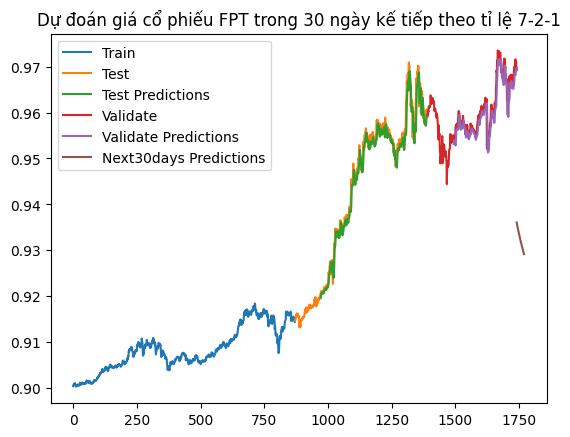

In [278]:
#Drawing plot
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(FPT1)-1, stop=len(FPT1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Test Predictions ','Validate','Validate Predictions','Next30days Predictions'])
plt.title("Dự đoán giá cổ phiếu FPT trong 30 ngày kế tiếp theo tỉ lệ 7-2-1")
plt.show()

# 5. Chia tập dữ liệu để train-test-validate theo tỉ lệ 6:3:1

In [237]:
# Split the data into training, testing, and validation sets
train_size = int(0.6 * len(FPT1))
test_size = int(0.3 * len(FPT1))
val_size = len(FPT1) - train_size - test_size

In [238]:
train_data = FPT1[:train_size]
test_data = FPT1[train_size:train_size+test_size]
val_data = FPT1[train_size+test_size:]

<h1>Hàm Create Dataset

In [239]:
#Chuyển mảng giá trị của dataset thành ma trận
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [240]:
import numpy
#Reshape into X=t,t+1, t+2... t+99 and Y= t+100
time_step =100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [241]:
#Reshape input to be [samples, time steps, features] which is required for GRU
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [242]:
#Define GRU model
model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [243]:
#Model fitting
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
15/15 [==============================] - 2s 56ms/step - loss: 0.0114 - val_loss: 0.0957
Epoch 2/100
15/15 [==============================] - 0s 32ms/step - loss: 0.0034 - val_loss: 0.1211
Epoch 3/100
15/15 [==============================] - 1s 33ms/step - loss: 0.0016 - val_loss: 0.0245
Epoch 4/100
15/15 [==============================] - 0s 33ms/step - loss: 4.9860e-04 - val_loss: 0.0019
Epoch 5/100
15/15 [==============================] - 1s 34ms/step - loss: 1.2196e-04 - val_loss: 0.0044
Epoch 6/100
15/15 [==============================] - 1s 34ms/step - loss: 1.1434e-04 - val_loss: 0.0018
Epoch 7/100
15/15 [==============================] - 1s 34ms/step - loss: 9.8032e-05 - val_loss: 0.0011
Epoch 8/100
15/15 [==============================] - 0s 34ms/step - loss: 9.6496e-05 - val_loss: 0.0013
Epoch 9/100
15/15 [==============================] - 1s 35ms/step - loss: 9.6002e-05 - val_loss: 0.0013
Epoch 10/100
15/15 [==============================] - 0s 33ms/step - loss: 9

<h1>Dự báo dữ liệu test, val

In [244]:
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

3/3 [==============================] - 0s 7ms/step


<h1>Chuẩn hóa dữ liệu

In [245]:
#Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [246]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
ytest

array([[0.95514231],
       [0.95499874],
       [0.95571659],
       [0.95571659],
       [0.95636309],
       [0.956578  ],
       [0.95535811],
       [0.95370662],
       [0.95456804],
       [0.95500315],
       [0.95442271],
       [0.95456804],
       [0.95493092],
       [0.95369693],
       [0.9523916 ],
       [0.95304427],
       [0.95304427],
       [0.95268138],
       [0.95311649],
       [0.95326182],
       [0.95340715],
       [0.95340715],
       [0.9552207 ],
       [0.95420515],
       [0.95391537],
       [0.9539876 ],
       [0.95420515],
       [0.95384226],
       [0.95442271],
       [0.95464026],
       [0.95507625],
       [0.95580115],
       [0.95485782],
       [0.95420515],
       [0.9539876 ],
       [0.95391537],
       [0.95362471],
       [0.9531896 ],
       [0.95384226],
       [0.9539876 ],
       [0.95384226],
       [0.95377004],
       [0.95500315],
       [0.95485782],
       [0.95485782],
       [0.95478559],
       [0.95812291],
       [0.958

In [247]:
yval = scaler.inverse_transform(yval.reshape(-1,1))
yval

array([[0.97356408],
       [0.97259521],
       [0.97233097],
       [0.97215481],
       [0.973476  ],
       [0.97268329],
       [0.97083362],
       [0.97224289],
       [0.97171442],
       [0.9730356 ],
       [0.97312368],
       [0.97162634],
       [0.97153826],
       [0.96942436],
       [0.96871972],
       [0.96942436],
       [0.96916012],
       [0.96810317],
       [0.96845549],
       [0.96757469],
       [0.96783893],
       [0.96704622],
       [0.96801509],
       [0.97056939],
       [0.97118594],
       [0.97180249],
       [0.97127402],
       [0.97100978],
       [0.97162634],
       [0.96836741],
       [0.96827933],
       [0.96739853],
       [0.96819125],
       [0.96651774],
       [0.96739853],
       [0.96642966],
       [0.96281842],
       [0.96299457],
       [0.96123299],
       [0.95947141],
       [0.96158531],
       [0.96475616],
       [0.96299457],
       [0.96431576],
       [0.9641396 ],
       [0.96792701],
       [0.96783893],
       [0.966

<h1>Đánh giá độ chính xác của thuật toán

In [248]:
# RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 0.0014734609373918788
Testing RMSE: 0.001430764534747415


In [249]:
#MAE
valid_mae = mean_absolute_error(yval,y_pred_val)
test_mae = mean_absolute_error(ytest, y_pred)
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation MAE: 0.001122406470173473
Testing MAE: 0.0010015506876150835


In [250]:
#MAPE
valid_mape = np.mean(np.abs((yval - y_pred_val) / yval))*100
test_mape = np.mean(np.abs((ytest - y_pred) / ytest))*100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

Validation MAPE: 0.11598306241670368
Testing MAPE: 0.10461246186664326


<h1>Quá trình dự đoán giá cổ phiếu trong 30 ngày tiếp theo

In [253]:

lst_output = []
n_steps = 30  # Adjust the sequence length as needed
i = 0

while i < 30:
    if len(temp_input) >= n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))

        # Print for debugging
        print("{} day input {}".format(i, x_input))

        yhat = model.predict(x_input, verbose=0)

        # Print for debugging
        print("{} day output {}".format(i, yhat))

        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, len(temp_input), 1))

        # Print for debugging
        print("{} day input {}".format(i, x_input))

        yhat = model.predict(x_input, verbose=0)

        # Print for debugging
        print("{} day output {}".format(i, yhat))

        temp_input.extend(yhat[0].tolist())
        i = i + 1

print(lst_output)


0 day input [[[0.9230955 ]
  [0.92189387]
  [0.90987754]
  [0.90867591]
  [0.9230955 ]
  [0.92069224]
  [0.92790203]
  [0.90386938]
  [0.90026448]
  [0.91468407]
  [0.92790203]
  [0.90146611]
  [0.90627264]
  [0.90026448]
  [0.90507101]
  [0.91228081]
  [0.91468407]
  [0.92069224]
  [0.93511183]
  [0.94953142]
  [0.95193469]
  [0.94352326]
  [0.94232163]
  [0.95193469]
  [0.97356408]
  [0.95433795]
  [0.96635428]
  [0.96635428]
  [0.93991836]
  [0.94712816]]]
0 day output [[0.9543334]]
1 day input [[[0.92189387]
  [0.90987754]
  [0.90867591]
  [0.9230955 ]
  [0.92069224]
  [0.92790203]
  [0.90386938]
  [0.90026448]
  [0.91468407]
  [0.92790203]
  [0.90146611]
  [0.90627264]
  [0.90026448]
  [0.90507101]
  [0.91228081]
  [0.91468407]
  [0.92069224]
  [0.93511183]
  [0.94953142]
  [0.95193469]
  [0.94352326]
  [0.94232163]
  [0.95193469]
  [0.97356408]
  [0.95433795]
  [0.96635428]
  [0.96635428]
  [0.93991836]
  [0.94712816]
  [0.95433342]]]
1 day output [[0.95852536]]
2 day input [[[0.

In [254]:
print(scaler.inverse_transform(lst_output))

[[0.97021674]
 [0.970524  ]
 [0.97089444]
 [0.97128876]
 [0.97169589]
 [0.97211131]
 [0.97253252]
 [0.97295796]
 [0.97338652]
 [0.97381747]
 [0.97425033]
 [0.97468459]
 [0.97511989]
 [0.9755559 ]
 [0.97599238]
 [0.97642902]
 [0.97686567]
 [0.97730205]
 [0.97773801]
 [0.97817339]
 [0.97860802]
 [0.97904173]
 [0.97947432]
 [0.9799056 ]
 [0.98033547]
 [0.98076382]
 [0.98119047]
 [0.98161532]
 [0.98203819]
 [0.98245888]]


<h1>Vẽ hình mô tả dự đoán

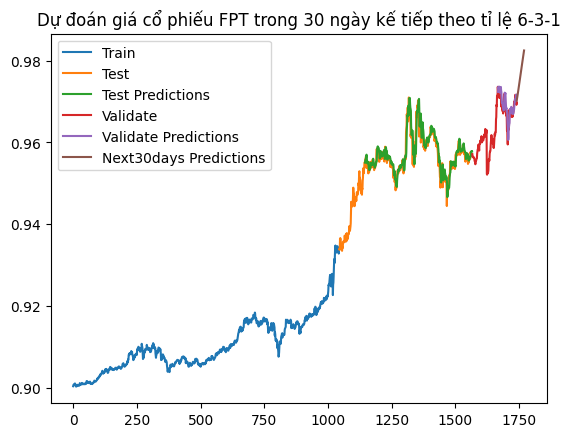

In [255]:
#Drawing plot
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(FPT1)-1, stop=len(FPT1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Test Predictions','Validate','Validate Predictions','Next30days Predictions'])
plt.title("Dự đoán giá cổ phiếu FPT trong 30 ngày kế tiếp theo tỉ lệ 6-3-1")
plt.show()

# 6. Chia tập dữ liệu để train-test-validate theo tỉ lệ 5:3:2

In [256]:
# Split the data into training, testing, and validation sets
train_size = int(0.5 * len(FPT1))
test_size = int(0.3 * len(FPT1))
val_size = len(FPT1) - train_size - test_size

In [257]:
train_data = FPT1[:train_size]
test_data = FPT1[train_size:train_size+test_size]
val_data = FPT1[train_size+test_size:]

<h1>Hàm Create Dataset

In [258]:
#Chuyển mảng giá trị của dataset thành ma trận
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [259]:
import numpy
#Reshape into X=t,t+1, t+2... t+99 and Y= t+100
time_step =100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [260]:
#Reshape input to be [samples, time steps, features] which is required for GRU
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [261]:
#Define GRU model
model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [262]:
#Model fitting
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 [==============================] - 2s 84ms/step - loss: 0.0080 - val_loss: 0.1228
Epoch 2/100
13/13 [==============================] - 1s 52ms/step - loss: 0.0025 - val_loss: 0.1713
Epoch 3/100
13/13 [==============================] - 0s 37ms/step - loss: 0.0014 - val_loss: 0.0859
Epoch 4/100
13/13 [==============================] - 0s 34ms/step - loss: 8.3416e-04 - val_loss: 0.0557
Epoch 5/100
13/13 [==============================] - 0s 32ms/step - loss: 4.2690e-04 - val_loss: 0.0122
Epoch 6/100
13/13 [==============================] - 0s 33ms/step - loss: 1.7264e-04 - val_loss: 0.0010
Epoch 7/100
13/13 [==============================] - 0s 34ms/step - loss: 9.1741e-05 - val_loss: 0.0016
Epoch 8/100
13/13 [==============================] - 0s 33ms/step - loss: 8.5348e-05 - val_loss: 7.9058e-04
Epoch 9/100
13/13 [==============================] - 0s 34ms/step - loss: 7.2054e-05 - val_loss: 8.7625e-04
Epoch 10/100
13/13 [==============================] - 0s 32ms/step -

<h1>Dự báo dữ liệu test, val

In [263]:
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

8/8 [==============================] - 0s 7ms/step


<h1>Chuẩn hóa dữ liệu

In [264]:
#Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [265]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
ytest

array([[0.92045787],
       [0.9205197 ],
       [0.92095279],
       [0.9207672 ],
       [0.9205197 ],
       [0.92082912],
       [0.92113846],
       [0.92064345],
       [0.9205197 ],
       [0.9207672 ],
       [0.9207672 ],
       [0.92082912],
       [0.92082912],
       [0.92113846],
       [0.9219428 ],
       [0.92132404],
       [0.92163346],
       [0.92175721],
       [0.92144779],
       [0.92169529],
       [0.92132404],
       [0.92157154],
       [0.9219428 ],
       [0.92231405],
       [0.9219428 ],
       [0.92163346],
       [0.92200463],
       [0.9221903 ],
       [0.92262338],
       [0.92231405],
       [0.92293281],
       [0.92361339],
       [0.92516024],
       [0.92497457],
       [0.92503649],
       [0.92553141],
       [0.92639767],
       [0.92707825],
       [0.92751143],
       [0.92744951],
       [0.92757326],
       [0.92738768],
       [0.92472707],
       [0.92553141],
       [0.9269545 ],
       [0.92775884],
       [0.92782076],
       [0.927

In [266]:
yval = scaler.inverse_transform(yval.reshape(-1,1))
yval

array([[0.95436281],
       [0.95436281],
       [0.95506745],
       [0.95365818],
       [0.95374626],
       [0.95392242],
       [0.95348202],
       [0.95409858],
       [0.95682903],
       [0.95682903],
       [0.95735751],
       [0.95709327],
       [0.95709327],
       [0.95718135],
       [0.95762174],
       [0.95744559],
       [0.95682903],
       [0.95753366],
       [0.95859061],
       [0.95982372],
       [0.96026412],
       [0.9603522 ],
       [0.96008796],
       [0.9599118 ],
       [0.95859061],
       [0.95850254],
       [0.95691711],
       [0.95726943],
       [0.95744559],
       [0.95788598],
       [0.95744559],
       [0.95744559],
       [0.95744559],
       [0.95753366],
       [0.9582383 ],
       [0.9582383 ],
       [0.9582383 ],
       [0.95929525],
       [0.95929525],
       [0.95841446],
       [0.95806214],
       [0.95753366],
       [0.95709327],
       [0.95726943],
       [0.95726943],
       [0.95682903],
       [0.95550784],
       [0.955

<h1>Đánh giá độ chính xác của thuật toán

In [267]:
# RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 0.001682142042219984
Testing RMSE: 0.001603180578763596


In [268]:
#MAE
valid_mae = mean_absolute_error(yval,y_pred_val)
test_mae = mean_absolute_error(ytest, y_pred)
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation MAE: 0.00132092116928591
Testing MAE: 0.001181150783588825


In [269]:
#MAPE
valid_mape = np.mean(np.abs((yval - y_pred_val) / yval))*100
test_mape = np.mean(np.abs((ytest - y_pred) / ytest))*100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

Validation MAPE: 0.13727656061972418
Testing MAPE: 0.12406879530785535


<h1>Quá trình dự đoán giá cổ phiếu trong 30 ngày tiếp theo

In [272]:

lst_output = []
n_steps = 30  # Adjust the sequence length as needed
i = 0

while i < 30:
    if len(temp_input) >= n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))

        # Print for debugging
        print("{} day input {}".format(i, x_input))

        yhat = model.predict(x_input, verbose=0)

        # Print for debugging
        print("{} day output {}".format(i, yhat))

        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, len(temp_input), 1))

        # Print for debugging
        print("{} day input {}".format(i, x_input))

        yhat = model.predict(x_input, verbose=0)

        # Print for debugging
        print("{} day output {}".format(i, yhat))

        temp_input.extend(yhat[0].tolist())
        i = i + 1

print(lst_output)


0 day input [[[0.92835891]
  [0.91699672]
  [0.90474057]
  [0.8924033 ]
  [0.88016737]
  [0.86810029]
  [0.85623676]
  [0.84459877]
  [0.83319974]
  [0.82204962]
  [0.81115443]
  [0.80051643]
  [0.79013497]
  [0.78000849]
  [0.77013308]
  [0.76050419]
  [0.75111651]
  [0.74196398]
  [0.7330395 ]
  [0.72433674]
  [0.71584827]
  [0.70756716]
  [0.69948542]
  [0.69159645]
  [0.68389291]
  [0.67636842]
  [0.66901594]
  [0.66182917]
  [0.65480191]
  [0.64792782]]]
0 day output [[0.64120144]]
1 day input [[[0.91699672]
  [0.90474057]
  [0.8924033 ]
  [0.88016737]
  [0.86810029]
  [0.85623676]
  [0.84459877]
  [0.83319974]
  [0.82204962]
  [0.81115443]
  [0.80051643]
  [0.79013497]
  [0.78000849]
  [0.77013308]
  [0.76050419]
  [0.75111651]
  [0.74196398]
  [0.7330395 ]
  [0.72433674]
  [0.71584827]
  [0.70756716]
  [0.69948542]
  [0.69159645]
  [0.68389291]
  [0.67636842]
  [0.66901594]
  [0.66182917]
  [0.65480191]
  [0.64792782]
  [0.64120144]]]
1 day output [[0.634617]]
2 day input [[[0.9

In [273]:
print(scaler.inverse_transform(lst_output))

[[0.94726429]
 [0.94678165]
 [0.94630905]
 [0.94584614]
 [0.94539253]
 [0.94494791]
 [0.94451198]
 [0.94408442]
 [0.94366497]
 [0.94325334]
 [0.94284929]
 [0.94245258]
 [0.94206297]
 [0.94168024]
 [0.94130419]
 [0.94093461]
 [0.94057131]
 [0.94021413]
 [0.93986285]
 [0.93951735]
 [0.93917747]
 [0.93884302]
 [0.9385139 ]
 [0.93818993]
 [0.93787101]
 [0.937557  ]
 [0.93724777]
 [0.93694322]
 [0.93664322]
 [0.93634767]]


<h1>Vẽ hình mô tả dự đoán

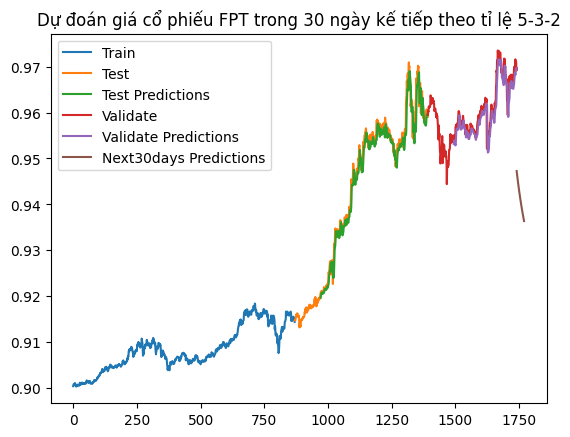

In [274]:
#Drawing plot
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(FPT1)-1, stop=len(FPT1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Test Predictions','Validate','Validate Predictions','Next30days Predictions'])
plt.title("Dự đoán giá cổ phiếu FPT trong 30 ngày kế tiếp theo tỉ lệ 5-3-2")
plt.show()